## Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import string

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Import the Dataset

In [2]:
df=pd.read_csv("NLP DATASET.csv");
df.columns=["questions","answers"];

df.head(10)

,questions,answers
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza..."
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...
5,What is community spread?,Community spread means people have been infect...
6,Can mosquitoes or ticks spread the virus that ...,"At this time, CDC has no data to suggest that ..."
7,Does CDC recommend the use of masks to prevent...,Wear masks in public settings when around peop...
8,Is it safe to get care for my other medical co...,It is important to continue taking care of you...
9,"Am I at risk for COVID-19 from mail, packages,...",There is still a lot that is unknown about COV...


## Preprocessing the dataset 

In [3]:
df = df.drop_duplicates(subset='questions')

In [4]:
df = df.dropna()

## Data Visualisation

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from textblob import TextBlob
from wordcloud import WordCloud
import sklearn

Populating the interactive namespace from numpy and matplotlib


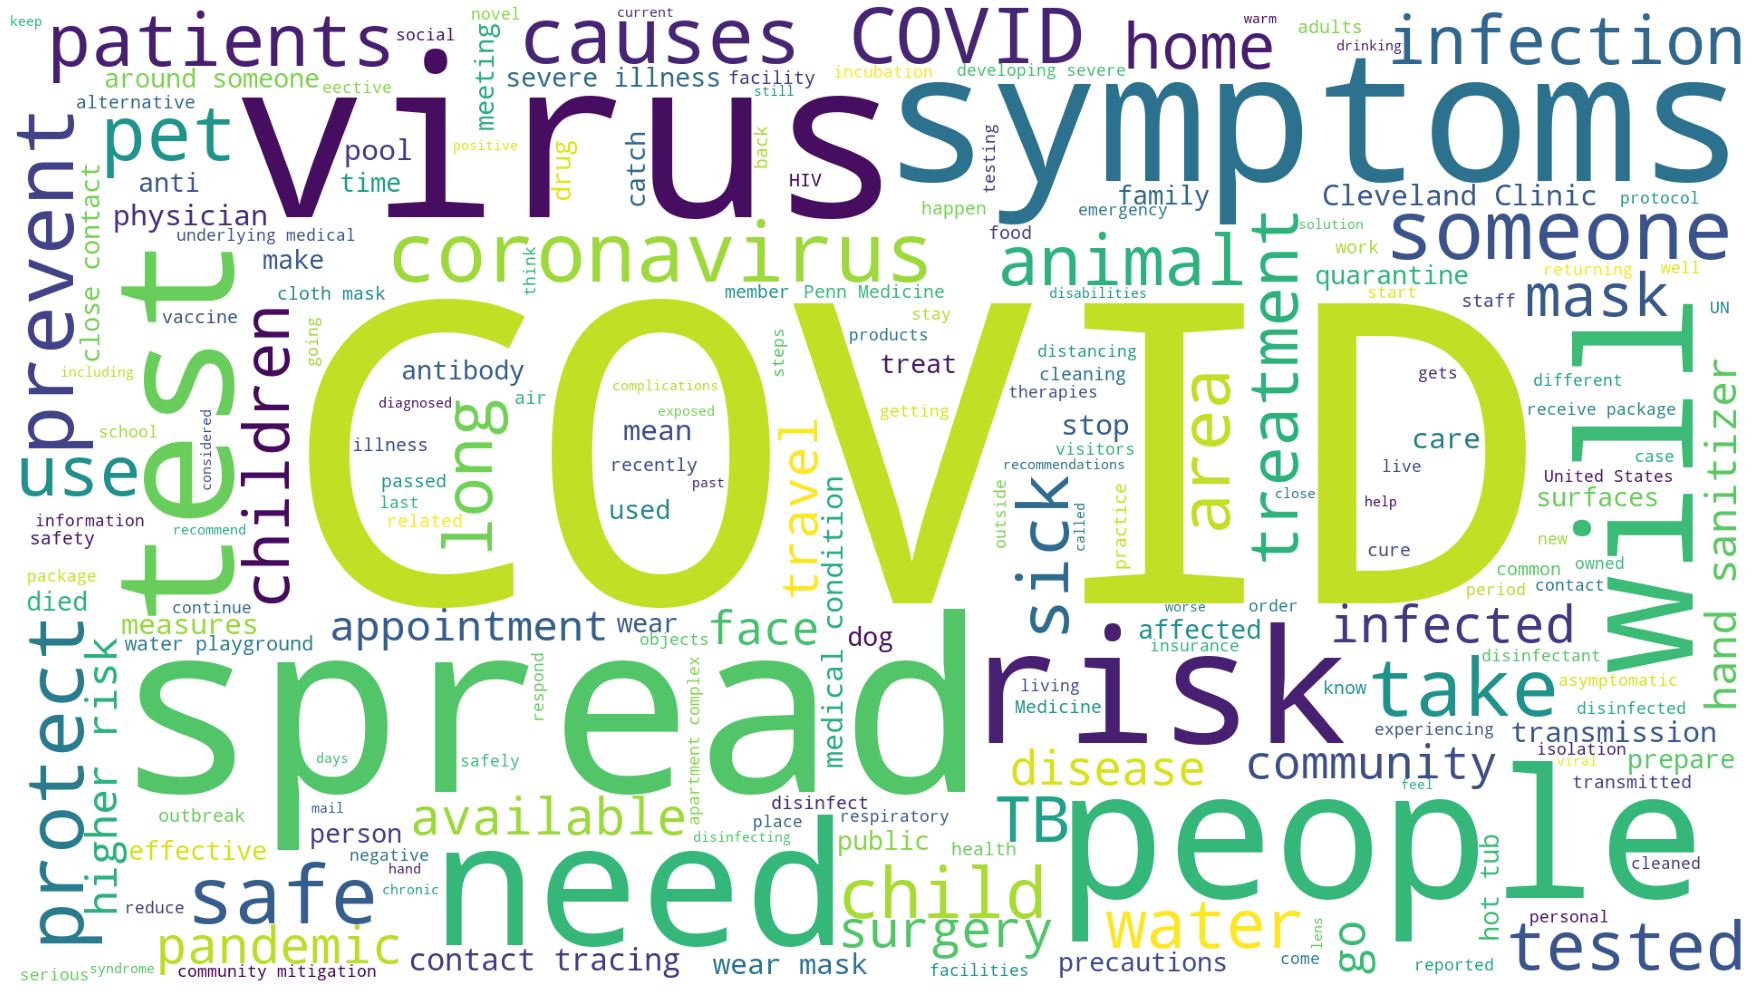

In [6]:
text = ' '.join(df.questions)
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(32, 18))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('questions_wordcloud.png')

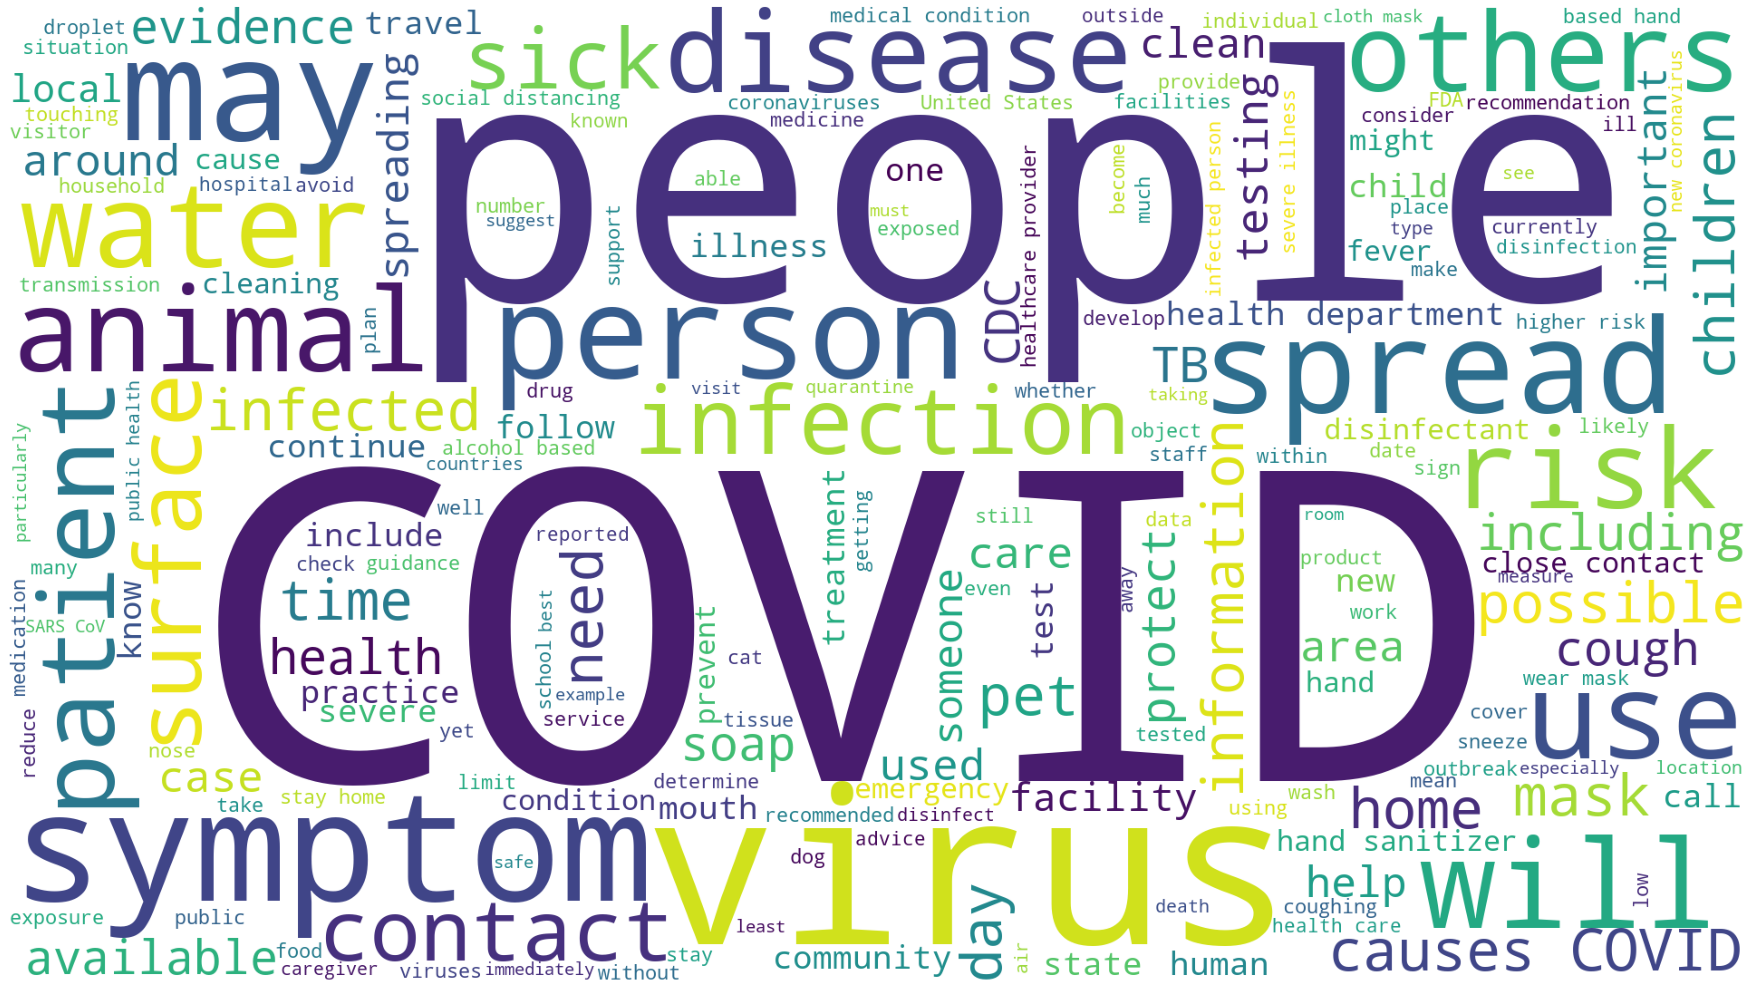

In [7]:
text = ' '.join(df.answers)
cloud = WordCloud(background_color='white', width=1920, height=1080).generate(text)
plt.figure(figsize=(32, 18))
plt.axis('off')
plt.imshow(cloud)
plt.savefig('questions_wordcloud.png')

In [8]:
get_polarity = lambda x: TextBlob(x).sentiment.polarity
get_subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

df['q_polarity'] = df.questions.apply(get_polarity)
df['a_polarity'] = df.answers.apply(get_polarity)
df['q_subjectivity'] = df.questions.apply(get_subjectivity)
df['a_subjectivity'] = df.answers.apply(get_subjectivity)

In [9]:
df.head(10)

,questions,answers,q_polarity,a_polarity,q_subjectivity,a_subjectivity
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...,0.000,-0.128139,0.000000,0.463745
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza...",0.000,0.113973,0.000000,0.347811
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...,0.000,0.166667,0.000000,0.633333
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...,0.000,0.176984,0.000000,0.582540
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...,0.600,-0.190882,0.600000,0.651786
5,What is community spread?,Community spread means people have been infect...,0.000,-0.125000,0.000000,0.444444
6,Can mosquitoes or ticks spread the virus that ...,"At this time, CDC has no data to suggest that ...",0.000,0.135606,0.000000,0.412576
7,Does CDC recommend the use of masks to prevent...,Wear masks in public settings when around peop...,0.000,-0.027451,0.000000,0.335294
8,Is it safe to get care for my other medical co...,It is important to continue taking care of you...,0.125,-0.052513,0.291667,0.470238
9,"Am I at risk for COVID-19 from mail, packages,...",There is still a lot that is unknown about COV...,0.000,0.138889,0.000000,0.527778


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


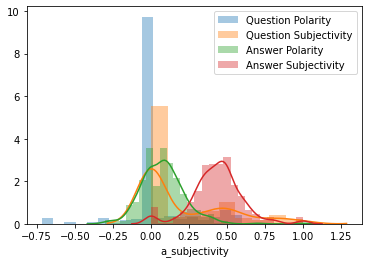

In [10]:
sns.distplot(df.q_polarity , label='Question Polarity')
sns.distplot(df.q_subjectivity , label='Question Subjectivity')
sns.distplot(df.a_polarity , label='Answer Polarity')
sns.distplot(df.a_subjectivity , label='Answer Subjectivity')
plt.legend()

## Function to clean dataset 

In [11]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords
def clean_sentence(sentence, stopwords=False):   
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
    
    if stopwords:
         sentence = remove_stopwords(sentence)
    return sentence

def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences_without_stopwords = get_cleaned_sentences(df,stopwords=True)
cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)

## Function to tokenize the dataset

In [12]:
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def my_tokenizer(doc):
    words = word_tokenize(doc)    
    pos_tags = pos_tag(words)
    non_stopwords = [w for w in pos_tags if not w[0].lower() in stopwords_list]
    non_punctuation = [w for w in non_stopwords if not w[0] in string.punctuation]
    lemmas = []
    for w in non_punctuation:
        if w[1].startswith('J'):
            pos = wordnet.ADJ
        elif w[1].startswith('V'):
            pos = wordnet.VERB
        elif w[1].startswith('N'):
            pos = wordnet.NOUN
        elif w[1].startswith('R'):
             pos = wordnet.ADV
        else:
            pos = wordnet.NOUN
        lemmas.append(lemmatizer.lemmatize(w[0], pos))
    return lemmas

## Function to get phrase embeddings

In [13]:
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)

def getPhraseEmbedding(phrase,embeddingmodel):                    
        samp=getWordVec('computer', embeddingmodel);
        vec=np.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            den=den+1;
            vec=vec+np.array(getWordVec(word,embeddingmodel));
        return vec.reshape(1, -1)

## Bag of Words Model

In [14]:
from gensim import corpora
import pprint

sentence_words = [[word for word in document.split() ]
         for document in cleaned_sentences_with_stopwords]

dictionary = corpora.Dictionary(sentence_words)
#for key, value in dictionary.items():
    #print(key, ' : ', value)

bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
#for sent,embedding in zip(sentences,bow_corpus):
 #   print(sent)
  #  print(embedding)

In [15]:
def ask_question_bow(question):
    question=clean_sentence(question,stopwords=False);
    question_embedding = dictionary.doc2bow(question.split())
    
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(bow_corpus):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
    print("*****BAG OF WORDS MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [16]:
ask_question_bow('What is coronavirus?')

*****BAG OF WORDS MODEL*****

Your question:		 what is coronavirus
Closest question found:	 Why is the disease being called coronavirus disease 2019, COVID-19?


Cosine Similarity: 100.00%


Answer: On February 11, 2020 the World Health Organization announced an ocial name for the disease that is causing the 2019 novel coronavirus outbreak, rst identied in Wuhan China. The new name of this disease is coronavirus disease 2019, abbreviated as COVID-19. In COVID-19, ‘CO’ stands for ‘corona,’ ‘VI’ for ‘virus,’ and ‘D’ for disease. Formerly, this disease was referred to as “2019 novel coronavirus” or “2019-nCoV”. There are many types of human coronaviruses including some that commonly cause mild upper-respiratory tract illnesses. COVID-19 is a new disease, caused by a novel (or new) coronavirus that has not previously been seen in humans.


## Word2Vec Model

In [17]:
from gensim.models import Word2Vec 
import gensim.downloader as api

v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("./w2vecmodel.mod")
    print("Saved glove model")

w2vec_embedding_size=len(v2w_model['computer']);

Loaded w2v model


In [18]:
def ask_question_w2v(question):
    sent_embeddings=[];
    for sent in cleaned_sentences_with_stopwords:
        sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

    question_embedding=getPhraseEmbedding(question,v2w_model);
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sent_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    print("*****WORD2VEC MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [19]:
ask_question_w2v('What is coronavirus?')

*****WORD2VEC MODEL*****

Your question:		 What is coronavirus?
Closest question found:	 What is COVID-19?


Cosine Similarity: 82.34%


Answer: COVID-19, otherwise known as coronavirus disease 2019, is a new illness that affects your lungs and airways. It is particularly severe in older populations and people with underlying health conditions.


## GloVe Model

In [20]:
glove_model=None;
try:
    glove_model = gensim.models.KeyedVectors.load("./glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")   
glove_embedding_size=len(glove_model['computer']);

Loaded glove model


In [21]:
def ask_question_glove(question):
    sent_embeddings=[];
    for sent in cleaned_sentences_with_stopwords:
        sent_embeddings.append(getPhraseEmbedding(sent,glove_model));
    question_embedding=getPhraseEmbedding(question,glove_model);
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sent_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    print("*****GLOVE MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [22]:
ask_question_glove('What is coronavirus')

*****GLOVE MODEL*****

Your question:		 What is coronavirus
Closest question found:	 What is coronavirus disease 2019 (COVID-19)?


Cosine Similarity: 93.36%


Answer: Coronavirus disease 2019 (COVID-19) is a respiratory illness that can spread from person to person. CDC has information on COVID-19 symptoms (https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html) and caring for yourself and others. COVID-19 is a new disease, caused by a novel (or new) coronavirus that has not previously been seen in humans.


## TF-IDF Model

In [23]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=my_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(tuple(df['questions']))

In [24]:
def ask_question_tfidf(question):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    
    print("*****TF-IDF MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df.iloc[max_similarity]['questions'])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(similarity[0, max_similarity]))
    print("\n")
    print('Answer:', df.iloc[max_similarity]['answers'])

In [25]:
ask_question_tfidf('What is coronavirus')

*****TF-IDF MODEL*****

Your question:		 What is coronavirus
Closest question found:	 What is a coronavirus?


Cosine Similarity: 100.00%


Answer: Coronaviruses are a large family of viruses which may cause illness in animals or humans. In humans, several coronaviruses are known to cause respiratory infections ranging from the common cold to more severe diseases such as Middle East Respiratory Syndrome (MERS) and Severe Acute Respiratory Syndrome (SARS). The most recently discovered coronavirus causes coronavirus disease COVID-19.


## BERT Model

In [26]:
from bert_serving.client import BertClient
bc = BertClient(check_length=False)
res=bc.encode(['ML', 'AI'])

In [40]:
def ask_question_bert(question):
    #question = clean_sentence(question,stopwords=False);

    sent_bertphrase_embeddings=[];
    for sent in cleaned_sentences_with_stopwords:
        sent_bertphrase_embeddings.append(bc.encode([sent]));

    question_embedding=bc.encode([question]);
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sent_bertphrase_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
            
    print("*****BERT MODEL*****\n")
    print('Your question:\t\t', question)
    print('Closest question found:\t', df['questions'].iloc[index_sim])
    print("\n")
    print('Cosine Similarity: {:.2%}'.format(max_sim))
    print("\n")
    print('Answer:', df.iloc[index_sim]['answers'])

In [33]:
ask_question_bert('What is coronavirus?')

*****BERT MODEL*****

Your question:		 what is coronavirus
Closest question found:	 What is a coronavirus?


Similarity: 98.71%


Answer: Coronaviruses are a large family of viruses which may cause illness in animals or humans. In humans, several coronaviruses are known to cause respiratory infections ranging from the common cold to more severe diseases such as Middle East Respiratory Syndrome (MERS) and Severe Acute Respiratory Syndrome (SARS). The most recently discovered coronavirus causes coronavirus disease COVID-19.


## Comparing accuracy of all models

In [34]:
def ask_question(question):
    ask_question_bow(question)
    print("\n--------------------\n")
    ask_question_w2v(question)
    print("\n--------------------\n")
    ask_question_glove(question)
    print("\n--------------------\n")
    ask_question_tfidf(question)
    print("\n--------------------\n")
    ask_question_bert(question)

In [41]:
question = "What are the symptoms of coronavirus?"

ask_question(question)

*****BAG OF WORDS MODEL*****

Your question:		 what are the symptoms of coronavirus
Closest question found:	 Why is the disease being called coronavirus disease 2019, COVID-19?


Cosine Similarity: 100.00%


Answer: On February 11, 2020 the World Health Organization announced an ocial name for the disease that is causing the 2019 novel coronavirus outbreak, rst identied in Wuhan China. The new name of this disease is coronavirus disease 2019, abbreviated as COVID-19. In COVID-19, ‘CO’ stands for ‘corona,’ ‘VI’ for ‘virus,’ and ‘D’ for disease. Formerly, this disease was referred to as “2019 novel coronavirus” or “2019-nCoV”. There are many types of human coronaviruses including some that commonly cause mild upper-respiratory tract illnesses. COVID-19 is a new disease, caused by a novel (or new) coronavirus that has not previously been seen in humans.

--------------------

*****WORD2VEC MODEL*****

Your question:		 What are the symptoms of coronavirus?
Closest question found:	 What are